In [2]:
# ============================================================
# 1) Imports
# ============================================================
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms.v2 import MixUp, CutMix
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import pandas as pd
import numpy as np
from torchvision.transforms import InterpolationMode


# ============================================================
# 2) Dataset Classes
# ============================================================
class LeukemiaDataset(Dataset):
    def __init__(self, root_dir, folds=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths, self.labels = [], []
        exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')

        if folds:
            for fold in folds:
                for label, category in enumerate(['all', 'hem']):
                    folder_path = os.path.join(root_dir, fold, category)
                    if not os.path.isdir(folder_path):
                        continue
                    for img_name in os.listdir(folder_path):
                        if img_name.lower().endswith(exts):
                            self.image_paths.append(os.path.join(folder_path, img_name))
                            self.labels.append(label)
        else:
            for label, category in enumerate(['all', 'hem']):
                folder_path = os.path.join(root_dir, category)
                if not os.path.isdir(folder_path):
                    continue
                for img_name in os.listdir(folder_path):
                    if img_name.lower().endswith(exts):
                        self.image_paths.append(os.path.join(folder_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


class LeukemiaCSVDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        if "new_names" not in self.data.columns or "labels" not in self.data.columns:
            raise ValueError("❌ CSV must contain 'new_names' and 'labels' columns.")
        self.filename_col = "new_names"
        print(f"✅ Using column '{self.filename_col}' for image names.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data.iloc[idx][self.filename_col]))
        image = Image.open(img_name).convert("RGB")
        label = int(self.data.iloc[idx]["labels"])
        if self.transform:
            image = self.transform(image)
        return image, label


# ============================================================
# 3) Transformations
# ============================================================
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.9, 1.1), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.GaussianBlur(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


# ============================================================
# 4) Load Data
# ============================================================
train_dir = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data"
val_dir = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data"
val_csv = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv"

train_raw = LeukemiaDataset(train_dir, folds=('fold_0', 'fold_1', 'fold_2'))
val_raw = LeukemiaCSVDataset(val_csv, val_dir)

all_paths = train_raw.image_paths + [os.path.join(val_dir, str(x)) for x in val_raw.data[val_raw.filename_col]]
all_labels = train_raw.labels + list(val_raw.data["labels"])

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, all_labels, test_size=0.3, stratify=all_labels, random_state=42)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

print("✅ Data Split Complete:")
print("Train:", Counter(train_labels))
print("Val:", Counter(val_labels))
print("Test:", Counter(test_labels))


# ============================================================
# 5) Dataset Wrappers
# ============================================================
class SubsetDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        lbl = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, lbl

train_dataset = SubsetDataset(train_paths, train_labels, transform_train)
val_dataset   = SubsetDataset(val_paths, val_labels, transform_val)
test_dataset  = SubsetDataset(test_paths, test_labels, transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# ============================================================
# 6) Model Setup (RESNET50)
# ============================================================
def get_model(num_classes=2):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model


# ============================================================
# 7) Training & Evaluation
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧩 Using device:", device)

mixup = MixUp(alpha=0.4, num_classes=2)
cutmix = CutMix(alpha=0.4, num_classes=2)

def apply_label_mix(inputs, targets):
    if torch.rand(1).item() > 0.5:
        return mixup(inputs, targets)
    else:
        return cutmix(inputs, targets)


def train_model(model, train_loader, val_loader, epochs=40, lr=3e-5, patience=6):
    model = model.to(device)
    class_counts = Counter(train_labels)
    total = sum(class_counts.values())
    weights = torch.tensor([total / class_counts[0], total / class_counts[1]], dtype=torch.float32).to(device)
    weights = weights / weights.sum()
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4,
                                                    steps_per_epoch=len(train_loader), epochs=epochs)

    best_val_acc, patience_counter = 0, 0
    print(f"🔧 Using class weights: {weights.cpu().numpy()}")

    for epoch in range(epochs):
        use_mix = epoch < 10  # only apply mixup/cutmix for first 10 epochs
        print(f"\n🌀 Epoch {epoch+1}/{epochs} {'(with MixUp/CutMix)' if use_mix else '(clean)'}")
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            mixed = False
            if use_mix and torch.rand(1).item() > 0.5:
                images, labels = apply_label_mix(images, labels)
                mixed = True

            optimizer.zero_grad()
            outputs = model(images)

            if labels.ndim == 2:
                loss = -(labels * torch.log_softmax(outputs, dim=1)).sum(dim=1).mean()
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

            if not mixed:
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total if total > 0 else 0
        avg_loss = total_loss / len(train_loader)

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = 100 * val_correct / val_total
        val_loss /= len(val_loader)
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "resnet50_best.pth")
            print(f"💾 Best model saved ({best_val_acc:.2f}%)")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping triggered.")
                break

    print("\n📊 Validation Classification Report:")
    print(classification_report(all_labels, all_preds))
    return model


def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n🧩 Test Classification Report:")
    print(classification_report(all_labels, all_preds))
    print("\n🔹 Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


# ============================================================
# 8) Train in Two Phases (like MobileNet)
# ============================================================
model = get_model(num_classes=2)

# ---- Phase 1: Train only classifier head ----
for param in list(model.children())[:-2]:  # freeze all except last layers
    for p in param.parameters():
        p.requires_grad = False
print("\n🔹 Phase 1: Training classifier head only (8 epochs)")
train_model(model, train_loader, val_loader, epochs=8, lr=1e-4, patience=3)

# ---- Phase 2: Fine-tune entire model ----
for param in model.parameters():
    param.requires_grad = True
print("\n🔹 Phase 2: Fine-tuning all layers (up to 80 epochs)")
trained_model = train_model(model, train_loader, val_loader, epochs=80, lr=3e-5, patience=10)

trained_model.load_state_dict(torch.load("resnet50_best.pth"))
evaluate_model(trained_model, test_loader)



✅ Using column 'new_names' for image names.
✅ Data Split Complete:
Train: Counter({0: 5544, 1: 3225})
Val: Counter({0: 1188, 1: 691})
Test: Counter({0: 1188, 1: 692})
🧩 Using device: cuda

🔹 Phase 1: Training classifier head only (8 epochs)
🔧 Using class weights: [0.36777285 0.6322271 ]

🌀 Epoch 1/8 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:12<00:00,  4.76it/s]


Epoch [1/8] Train Loss: 0.6810 | Train Acc: 61.20% | Val Loss: 0.6971 | Val Acc: 65.30%
💾 Best model saved (65.30%)

🌀 Epoch 2/8 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.54it/s]


Epoch [2/8] Train Loss: 0.6589 | Train Acc: 68.14% | Val Loss: 0.6699 | Val Acc: 69.82%
💾 Best model saved (69.82%)

🌀 Epoch 3/8 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


Epoch [3/8] Train Loss: 0.6346 | Train Acc: 69.48% | Val Loss: 0.6484 | Val Acc: 70.84%
💾 Best model saved (70.84%)

🌀 Epoch 4/8 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:07<00:00,  8.22it/s]


Epoch [4/8] Train Loss: 0.6258 | Train Acc: 68.42% | Val Loss: 0.7078 | Val Acc: 69.61%

🌀 Epoch 5/8 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.51it/s]


Epoch [5/8] Train Loss: 0.6262 | Train Acc: 70.04% | Val Loss: 0.6316 | Val Acc: 71.69%
💾 Best model saved (71.69%)

🌀 Epoch 6/8 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


Epoch [6/8] Train Loss: 0.6239 | Train Acc: 70.72% | Val Loss: 0.6425 | Val Acc: 71.15%

🌀 Epoch 7/8 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


Epoch [7/8] Train Loss: 0.6135 | Train Acc: 71.76% | Val Loss: 0.6603 | Val Acc: 71.10%

🌀 Epoch 8/8 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:07<00:00,  8.41it/s]


Epoch [8/8] Train Loss: 0.6165 | Train Acc: 70.34% | Val Loss: 0.6502 | Val Acc: 71.26%
⏹️ Early stopping triggered.

📊 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.93      0.80      1188
           1       0.74      0.34      0.47       691

    accuracy                           0.71      1879
   macro avg       0.72      0.63      0.63      1879
weighted avg       0.72      0.71      0.68      1879


🔹 Phase 2: Fine-tuning all layers (up to 80 epochs)
🔧 Using class weights: [0.36777285 0.6322271 ]

🌀 Epoch 1/80 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch [1/80] Train Loss: 0.6002 | Train Acc: 72.02% | Val Loss: 0.6224 | Val Acc: 71.58%
💾 Best model saved (71.58%)

🌀 Epoch 2/80 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch [2/80] Train Loss: 0.5816 | Train Acc: 74.81% | Val Loss: 0.5458 | Val Acc: 73.87%
💾 Best model saved (73.87%)

🌀 Epoch 3/80 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch [3/80] Train Loss: 0.5599 | Train Acc: 74.55% | Val Loss: 0.5325 | Val Acc: 72.49%

🌀 Epoch 4/80 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch [4/80] Train Loss: 0.5519 | Train Acc: 76.61% | Val Loss: 0.5153 | Val Acc: 73.28%

🌀 Epoch 5/80 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch [5/80] Train Loss: 0.5397 | Train Acc: 77.43% | Val Loss: 0.5524 | Val Acc: 63.81%

🌀 Epoch 6/80 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch [6/80] Train Loss: 0.5321 | Train Acc: 77.59% | Val Loss: 0.4704 | Val Acc: 78.39%
💾 Best model saved (78.39%)

🌀 Epoch 7/80 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch [7/80] Train Loss: 0.5286 | Train Acc: 77.84% | Val Loss: 0.4995 | Val Acc: 75.47%

🌀 Epoch 8/80 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch [8/80] Train Loss: 0.5157 | Train Acc: 77.88% | Val Loss: 0.4727 | Val Acc: 76.90%

🌀 Epoch 9/80 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch [9/80] Train Loss: 0.5149 | Train Acc: 79.31% | Val Loss: 0.5522 | Val Acc: 78.50%
💾 Best model saved (78.50%)

🌀 Epoch 10/80 (with MixUp/CutMix)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch [10/80] Train Loss: 0.5073 | Train Acc: 78.42% | Val Loss: 0.4295 | Val Acc: 80.79%
💾 Best model saved (80.79%)

🌀 Epoch 11/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch [11/80] Train Loss: 0.4689 | Train Acc: 78.08% | Val Loss: 0.4888 | Val Acc: 68.01%

🌀 Epoch 12/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Epoch [12/80] Train Loss: 0.4631 | Train Acc: 77.63% | Val Loss: 0.5074 | Val Acc: 75.68%

🌀 Epoch 13/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch [13/80] Train Loss: 0.4499 | Train Acc: 78.86% | Val Loss: 0.4827 | Val Acc: 73.02%

🌀 Epoch 14/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch [14/80] Train Loss: 0.4396 | Train Acc: 79.66% | Val Loss: 0.4193 | Val Acc: 79.78%

🌀 Epoch 15/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch [15/80] Train Loss: 0.4355 | Train Acc: 79.70% | Val Loss: 0.4606 | Val Acc: 81.80%
💾 Best model saved (81.80%)

🌀 Epoch 16/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.59it/s]


Epoch [16/80] Train Loss: 0.4290 | Train Acc: 80.50% | Val Loss: 0.5152 | Val Acc: 71.42%

🌀 Epoch 17/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch [17/80] Train Loss: 0.4142 | Train Acc: 81.34% | Val Loss: 0.3894 | Val Acc: 82.92%
💾 Best model saved (82.92%)

🌀 Epoch 18/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [18/80] Train Loss: 0.4167 | Train Acc: 80.26% | Val Loss: 0.4128 | Val Acc: 82.76%

🌀 Epoch 19/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch [19/80] Train Loss: 0.4088 | Train Acc: 81.41% | Val Loss: 0.5035 | Val Acc: 72.33%

🌀 Epoch 20/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch [20/80] Train Loss: 0.4034 | Train Acc: 81.48% | Val Loss: 0.4139 | Val Acc: 78.45%

🌀 Epoch 21/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [21/80] Train Loss: 0.4033 | Train Acc: 81.39% | Val Loss: 0.4452 | Val Acc: 71.37%

🌀 Epoch 22/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch [22/80] Train Loss: 0.3903 | Train Acc: 82.29% | Val Loss: 0.4449 | Val Acc: 82.49%

🌀 Epoch 23/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.71it/s]


Epoch [23/80] Train Loss: 0.3832 | Train Acc: 83.01% | Val Loss: 0.4050 | Val Acc: 79.62%

🌀 Epoch 24/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch [24/80] Train Loss: 0.3844 | Train Acc: 82.50% | Val Loss: 0.3851 | Val Acc: 81.53%

🌀 Epoch 25/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch [25/80] Train Loss: 0.3767 | Train Acc: 82.92% | Val Loss: 0.4325 | Val Acc: 82.97%
💾 Best model saved (82.97%)

🌀 Epoch 26/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch [26/80] Train Loss: 0.3656 | Train Acc: 83.24% | Val Loss: 0.4104 | Val Acc: 76.05%

🌀 Epoch 27/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch [27/80] Train Loss: 0.3622 | Train Acc: 83.16% | Val Loss: 0.3834 | Val Acc: 80.63%

🌀 Epoch 28/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch [28/80] Train Loss: 0.3610 | Train Acc: 83.04% | Val Loss: 0.3706 | Val Acc: 83.29%
💾 Best model saved (83.29%)

🌀 Epoch 29/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [29/80] Train Loss: 0.3650 | Train Acc: 83.64% | Val Loss: 0.5425 | Val Acc: 64.02%

🌀 Epoch 30/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Epoch [30/80] Train Loss: 0.3486 | Train Acc: 84.43% | Val Loss: 0.3799 | Val Acc: 79.19%

🌀 Epoch 31/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch [31/80] Train Loss: 0.3467 | Train Acc: 84.70% | Val Loss: 0.3716 | Val Acc: 83.02%

🌀 Epoch 32/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [32/80] Train Loss: 0.3422 | Train Acc: 85.25% | Val Loss: 0.4047 | Val Acc: 82.54%

🌀 Epoch 33/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [33/80] Train Loss: 0.3260 | Train Acc: 85.15% | Val Loss: 0.4436 | Val Acc: 86.38%
💾 Best model saved (86.38%)

🌀 Epoch 34/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch [34/80] Train Loss: 0.3280 | Train Acc: 85.95% | Val Loss: 0.3869 | Val Acc: 86.06%

🌀 Epoch 35/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch [35/80] Train Loss: 0.3190 | Train Acc: 85.83% | Val Loss: 0.5067 | Val Acc: 82.65%

🌀 Epoch 36/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch [36/80] Train Loss: 0.3161 | Train Acc: 86.38% | Val Loss: 0.3223 | Val Acc: 86.27%

🌀 Epoch 37/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch [37/80] Train Loss: 0.3153 | Train Acc: 86.12% | Val Loss: 0.3451 | Val Acc: 85.84%

🌀 Epoch 38/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.60it/s]


Epoch [38/80] Train Loss: 0.2977 | Train Acc: 86.86% | Val Loss: 0.3766 | Val Acc: 83.98%

🌀 Epoch 39/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch [39/80] Train Loss: 0.2922 | Train Acc: 87.76% | Val Loss: 0.3451 | Val Acc: 87.76%
💾 Best model saved (87.76%)

🌀 Epoch 40/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch [40/80] Train Loss: 0.2783 | Train Acc: 87.99% | Val Loss: 0.3272 | Val Acc: 87.01%

🌀 Epoch 41/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch [41/80] Train Loss: 0.2835 | Train Acc: 87.83% | Val Loss: 0.4069 | Val Acc: 81.43%

🌀 Epoch 42/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch [42/80] Train Loss: 0.2835 | Train Acc: 88.35% | Val Loss: 0.3569 | Val Acc: 83.71%

🌀 Epoch 43/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [43/80] Train Loss: 0.2832 | Train Acc: 88.16% | Val Loss: 0.3380 | Val Acc: 85.26%

🌀 Epoch 44/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch [44/80] Train Loss: 0.2698 | Train Acc: 88.53% | Val Loss: 0.3413 | Val Acc: 85.47%

🌀 Epoch 45/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch [45/80] Train Loss: 0.2553 | Train Acc: 89.21% | Val Loss: 0.2858 | Val Acc: 87.33%

🌀 Epoch 46/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch [46/80] Train Loss: 0.2481 | Train Acc: 89.63% | Val Loss: 0.3104 | Val Acc: 88.03%
💾 Best model saved (88.03%)

🌀 Epoch 47/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [47/80] Train Loss: 0.2433 | Train Acc: 89.84% | Val Loss: 0.3851 | Val Acc: 83.71%

🌀 Epoch 48/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch [48/80] Train Loss: 0.2411 | Train Acc: 90.14% | Val Loss: 0.3222 | Val Acc: 87.01%

🌀 Epoch 49/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [49/80] Train Loss: 0.2385 | Train Acc: 90.04% | Val Loss: 0.3426 | Val Acc: 86.70%

🌀 Epoch 50/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch [50/80] Train Loss: 0.2196 | Train Acc: 90.92% | Val Loss: 0.3321 | Val Acc: 85.58%

🌀 Epoch 51/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch [51/80] Train Loss: 0.2155 | Train Acc: 90.69% | Val Loss: 0.2775 | Val Acc: 88.88%
💾 Best model saved (88.88%)

🌀 Epoch 52/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.65it/s]


Epoch [52/80] Train Loss: 0.2113 | Train Acc: 91.36% | Val Loss: 0.3191 | Val Acc: 87.33%

🌀 Epoch 53/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.73it/s]


Epoch [53/80] Train Loss: 0.2196 | Train Acc: 90.64% | Val Loss: 0.3021 | Val Acc: 86.91%

🌀 Epoch 54/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [54/80] Train Loss: 0.1974 | Train Acc: 91.98% | Val Loss: 0.2851 | Val Acc: 89.41%
💾 Best model saved (89.41%)

🌀 Epoch 55/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch [55/80] Train Loss: 0.1917 | Train Acc: 91.78% | Val Loss: 0.3505 | Val Acc: 85.63%

🌀 Epoch 56/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Epoch [56/80] Train Loss: 0.1813 | Train Acc: 92.61% | Val Loss: 0.2664 | Val Acc: 89.52%
💾 Best model saved (89.52%)

🌀 Epoch 57/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [57/80] Train Loss: 0.1783 | Train Acc: 92.77% | Val Loss: 0.3138 | Val Acc: 89.36%

🌀 Epoch 58/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [58/80] Train Loss: 0.1667 | Train Acc: 93.19% | Val Loss: 0.2760 | Val Acc: 90.37%
💾 Best model saved (90.37%)

🌀 Epoch 59/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [59/80] Train Loss: 0.1605 | Train Acc: 93.25% | Val Loss: 0.3141 | Val Acc: 90.10%

🌀 Epoch 60/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.71it/s]


Epoch [60/80] Train Loss: 0.1606 | Train Acc: 93.53% | Val Loss: 0.2807 | Val Acc: 89.73%

🌀 Epoch 61/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch [61/80] Train Loss: 0.1557 | Train Acc: 93.56% | Val Loss: 0.2822 | Val Acc: 90.69%
💾 Best model saved (90.69%)

🌀 Epoch 62/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [62/80] Train Loss: 0.1468 | Train Acc: 94.36% | Val Loss: 0.2924 | Val Acc: 90.31%

🌀 Epoch 63/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Epoch [63/80] Train Loss: 0.1462 | Train Acc: 94.28% | Val Loss: 0.3024 | Val Acc: 89.84%

🌀 Epoch 64/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch [64/80] Train Loss: 0.1350 | Train Acc: 94.70% | Val Loss: 0.2871 | Val Acc: 89.30%

🌀 Epoch 65/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch [65/80] Train Loss: 0.1334 | Train Acc: 94.69% | Val Loss: 0.3047 | Val Acc: 89.14%

🌀 Epoch 66/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s]


Epoch [66/80] Train Loss: 0.1255 | Train Acc: 95.21% | Val Loss: 0.2921 | Val Acc: 90.90%
💾 Best model saved (90.90%)

🌀 Epoch 67/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.73it/s]


Epoch [67/80] Train Loss: 0.1230 | Train Acc: 94.96% | Val Loss: 0.2884 | Val Acc: 89.94%

🌀 Epoch 68/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.63it/s]


Epoch [68/80] Train Loss: 0.1138 | Train Acc: 95.62% | Val Loss: 0.3075 | Val Acc: 90.58%

🌀 Epoch 69/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Epoch [69/80] Train Loss: 0.1141 | Train Acc: 95.67% | Val Loss: 0.3278 | Val Acc: 89.41%

🌀 Epoch 70/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.61it/s]


Epoch [70/80] Train Loss: 0.1074 | Train Acc: 95.62% | Val Loss: 0.2891 | Val Acc: 90.53%

🌀 Epoch 71/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.62it/s]


Epoch [71/80] Train Loss: 0.1132 | Train Acc: 95.81% | Val Loss: 0.3041 | Val Acc: 90.63%

🌀 Epoch 72/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.64it/s]


Epoch [72/80] Train Loss: 0.0938 | Train Acc: 96.03% | Val Loss: 0.3060 | Val Acc: 90.42%

🌀 Epoch 73/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.68it/s]


Epoch [73/80] Train Loss: 0.1007 | Train Acc: 96.03% | Val Loss: 0.3089 | Val Acc: 90.10%

🌀 Epoch 74/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.69it/s]


Epoch [74/80] Train Loss: 0.0998 | Train Acc: 96.08% | Val Loss: 0.3120 | Val Acc: 90.26%

🌀 Epoch 75/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.70it/s]


Epoch [75/80] Train Loss: 0.1017 | Train Acc: 96.16% | Val Loss: 0.3269 | Val Acc: 90.15%

🌀 Epoch 76/80 (clean)


Validation: 100%|██████████| 59/59 [00:06<00:00,  8.66it/s]


Epoch [76/80] Train Loss: 0.0974 | Train Acc: 96.18% | Val Loss: 0.3090 | Val Acc: 90.42%
⏹️ Early stopping triggered.

📊 Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1188
           1       0.86      0.89      0.87       691

    accuracy                           0.90      1879
   macro avg       0.90      0.90      0.90      1879
weighted avg       0.91      0.90      0.90      1879



Testing: 100%|██████████| 59/59 [00:13<00:00,  4.46it/s]


🧩 Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1188
           1       0.88      0.81      0.84       692

    accuracy                           0.89      1880
   macro avg       0.89      0.87      0.88      1880
weighted avg       0.89      0.89      0.89      1880


🔹 Confusion Matrix:
 [[1113   75]
 [ 132  560]]


100%|██████████| 59/59 [00:07<00:00,  8.36it/s]


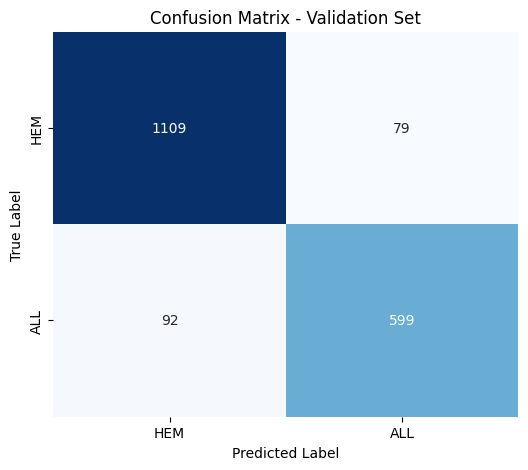

<Figure size 600x400 with 0 Axes>

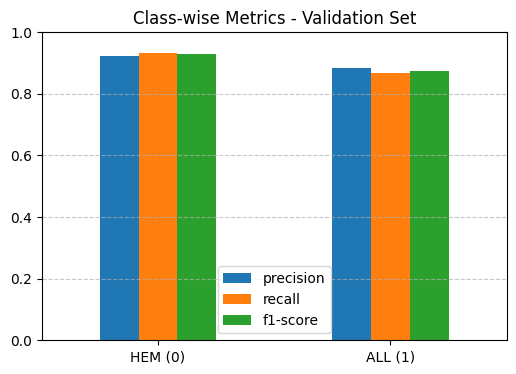


📋 Detailed Report:
              precision    recall  f1-score      support
0              0.923397  0.933502  0.928422  1188.000000
1              0.883481  0.866860  0.875091   691.000000
accuracy       0.908994  0.908994  0.908994     0.908994
macro avg      0.903439  0.900181  0.901757  1879.000000
weighted avg   0.908718  0.908994  0.908810  1879.000000


100%|██████████| 59/59 [00:07<00:00,  8.02it/s]


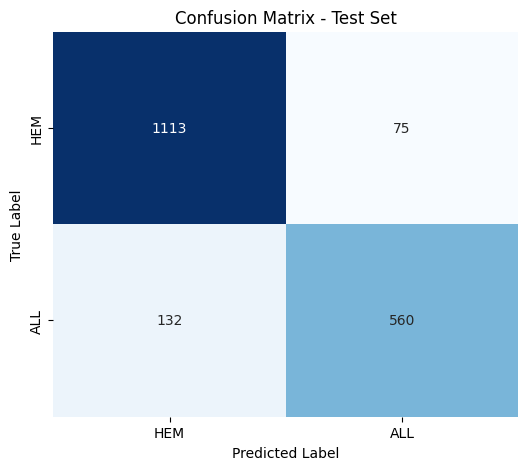

<Figure size 600x400 with 0 Axes>

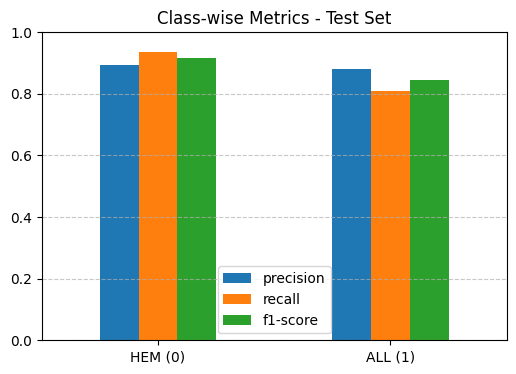


📋 Detailed Report:
              precision    recall  f1-score      support
0              0.893976  0.936869  0.914920  1188.000000
1              0.881890  0.809249  0.844009   692.000000
accuracy       0.889894  0.889894  0.889894     0.889894
macro avg      0.887933  0.873059  0.879464  1880.000000
weighted avg   0.889527  0.889894  0.888819  1880.000000


In [3]:
# ============================================================
#  📊 Classification Plots for Validation and Test Results
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

def plot_classification_results(y_true, y_pred, title="Classification Results"):
    # Compute metrics
    from sklearn.metrics import classification_report, confusion_matrix
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    # Convert classification report to DataFrame
    import pandas as pd
    report_df = pd.DataFrame(report).transpose()

    # --- Plot confusion matrix ---
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['HEM', 'ALL'], yticklabels=['HEM', 'ALL'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    # --- Plot precision / recall / f1 per class ---
    plt.figure(figsize=(6,4))
    metrics = report_df.loc[['0','1'], ['precision','recall','f1-score']]
    metrics.plot(kind='bar', figsize=(6,4), legend=True)
    plt.title(f"Class-wise Metrics - {title}")
    plt.xticks(ticks=[0,1], labels=['HEM (0)','ALL (1)'], rotation=0)
    plt.ylim(0,1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("\n📋 Detailed Report:")
    print(pd.DataFrame(report).transpose())

# ============================================================
# 🧩 Example usage (after evaluating model)
# ============================================================

# Collect validation predictions
def collect_predictions(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds)

# --- Validation set ---
val_y, val_pred = collect_predictions(trained_model, val_loader)
plot_classification_results(val_y, val_pred, title="Validation Set")

# --- Test set ---
test_y, test_pred = collect_predictions(trained_model, test_loader)
plot_classification_results(test_y, test_pred, title="Test Set")


100%|██████████| 59/59 [00:06<00:00,  8.47it/s]


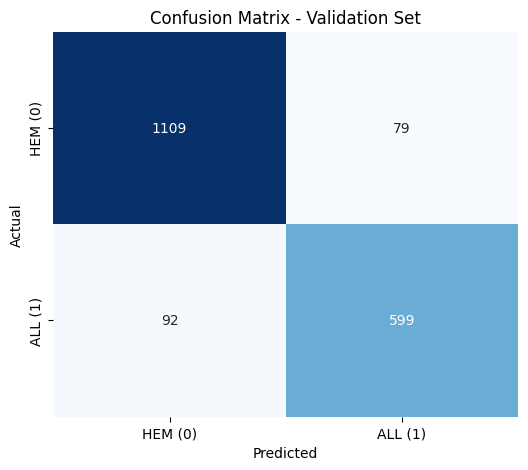

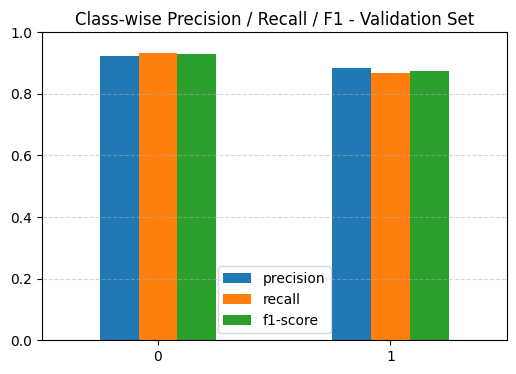


📋 Detailed Classification Report:
              precision    recall  f1-score      support
0              0.923397  0.933502  0.928422  1188.000000
1              0.883481  0.866860  0.875091   691.000000
accuracy       0.908994  0.908994  0.908994     0.908994
macro avg      0.903439  0.900181  0.901757  1879.000000
weighted avg   0.908718  0.908994  0.908810  1879.000000


100%|██████████| 59/59 [00:07<00:00,  8.16it/s]


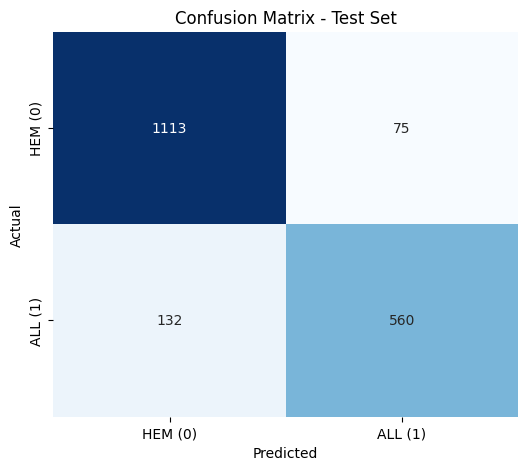

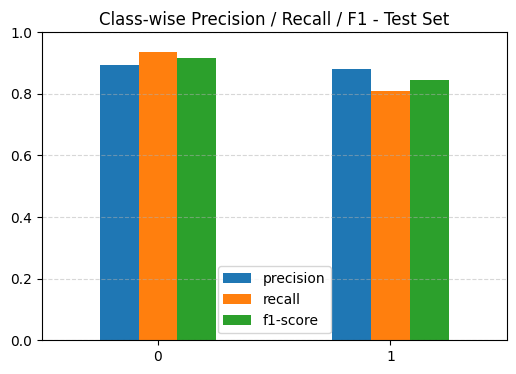


📋 Detailed Classification Report:
              precision    recall  f1-score      support
0              0.893976  0.936869  0.914920  1188.000000
1              0.881890  0.809249  0.844009   692.000000
accuracy       0.889894  0.889894  0.889894     0.889894
macro avg      0.887933  0.873059  0.879464  1880.000000
weighted avg   0.889527  0.889894  0.888819  1880.000000


In [4]:
# ============================================================
# 📈 Training & Validation Curves + Classification Plots
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# ---- 1️⃣: Track metrics during training ----
# (Make sure your train_model() returns these values when you modify it)
# Example of return: model, history_dict
# history_dict = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

def plot_training_curves(history):
    plt.figure(figsize=(12,5))

    # --- Loss curve ---
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- Accuracy curve ---
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# ---- 2️⃣: Confusion Matrix & Class-wise Metrics ----
def plot_classification_results(y_true, y_pred, title="Classification Results"):
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    # --- Confusion Matrix ---
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['HEM (0)', 'ALL (1)'],
                yticklabels=['HEM (0)', 'ALL (1)'])
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # --- Class-wise Metrics ---
    metrics = pd.DataFrame(report).transpose().iloc[:2, :3]  # only class 0,1
    metrics.plot(kind='bar', figsize=(6,4))
    plt.title(f"Class-wise Precision / Recall / F1 - {title}")
    plt.ylim(0,1)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    print("\n📋 Detailed Classification Report:")
    print(pd.DataFrame(report).transpose())


# ---- 3️⃣: Collect Predictions from DataLoader ----
def collect_predictions(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_labels), np.array(all_preds)


# ============================================================
# 🧩 Example Usage
# ============================================================
# Suppose you updated your train_model() to return a history dict:
# model, history = train_model(...)

# Plot training progress
# plot_training_curves(history)

# Collect Validation predictions
val_y, val_pred = collect_predictions(trained_model, val_loader)
plot_classification_results(val_y, val_pred, title="Validation Set")

# Collect Test predictions
test_y, test_pred = collect_predictions(trained_model, test_loader)
plot_classification_results(test_y, test_pred, title="Test Set")


ROC - Validation Set: 100%|██████████| 59/59 [00:06<00:00,  8.44it/s]


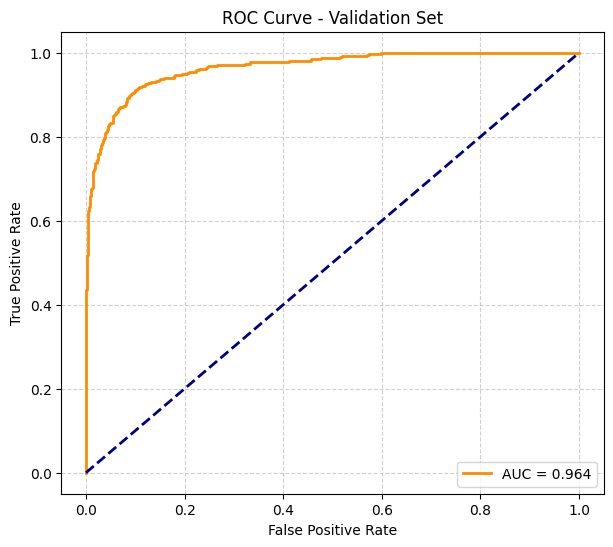

🔥 Validation Set AUC = 0.9644


ROC - Test Set: 100%|██████████| 59/59 [00:07<00:00,  8.09it/s]


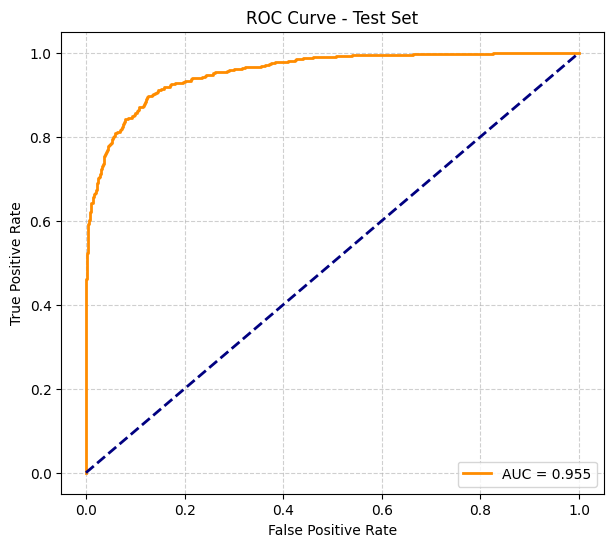

🔥 Test Set AUC = 0.9546


In [5]:
# ============================================================
#  📈 ROC & AUC Curves for Validation and Test Sets
# ============================================================
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(model, loader, title="ROC Curve"):
    model.eval()
    y_true, y_probs = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"ROC - {title}"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1 (ALL)
            y_true.extend(labels.numpy())
            y_probs.extend(probs.cpu().numpy())

    # Convert to arrays
    y_true, y_probs = np.array(y_true), np.array(y_probs)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)

    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'AUC = {auc_score:.3f}')
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {title}")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print(f"🔥 {title} AUC = {auc_score:.4f}")
    return auc_score


# ============================================================
# 🧩 Example Usage
# ============================================================

# Validation ROC–AUC
val_auc = plot_roc_curve(trained_model, val_loader, title="Validation Set")

# Test ROC–AUC
test_auc = plot_roc_curve(trained_model, test_loader, title="Test Set")
